In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
import nltk

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [8]:
# Define paths to the directories containing the train and test datasets

train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [9]:
# TRAINING DATA SUMMARY
print("PRINTING LABELS INFO")
print(train_df.info())
print("PRINTING FIRST 5 ROWS OF THE TRAINING DATA SET")
print(train_df.head())

PRINTING LABELS INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
PRINTING FIRST 5 ROWS OF THE TRAINING DATA SET
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2   

In [10]:
print("PRITNTING SUMMARY OF THE TRAINING DATASET")
print(train_df.describe())

PRITNTING SUMMARY OF THE TRAINING DATASET
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


In [11]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [12]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [13]:
duplicate_text_counts = train_df.duplicated(subset='text').sum()
duplicate_text_cat_counts = train_df.duplicated(subset='text').sum()

print(duplicate_text_counts)
print(duplicate_text_cat_counts)

duplicates = train_df[train_df.duplicated(subset='text', keep = False)].sort_values(by='text')
print(duplicates.head(15))

110
110
        id         keyword                    location  \
4290  6094        hellfire    Jubail IC, Saudi Arabia.   
4299  6105        hellfire  ?????? ??? ?????? ????????   
4312  6123        hellfire          ?????? ???? ??????   
6363  9095  suicide%20bomb                     Nigeria   
6373  9107  suicide%20bomb                     Nigeria   
6377  9113  suicide%20bomb                     Nigeria   
6378  9114  suicide%20bomb                     Nigeria   
6392  9135  suicide%20bomb                     Nigeria   
6366  9098  suicide%20bomb                     Nigeria   
2828  4064       displaced                         NaN   
2822  4057       displaced                         NaN   
2816  4049       displaced    Pedophile hunting ground   
2841  4086       displaced    Pedophile hunting ground   
1704  2459        collided            Peterborough, On   
1725  2488        collided          Peterborough, Ont.   

                                                   text  target

In [14]:
train_df1 = train_df.drop_duplicates(subset='text')

print(train_df1.head())
print("\n")
print("Training Data INFO:\n")
print(train_df1.info())
print("\n")

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


Training Data INFO:

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB
None




target
0    4305
1    3198
Name: count, dtype: int64


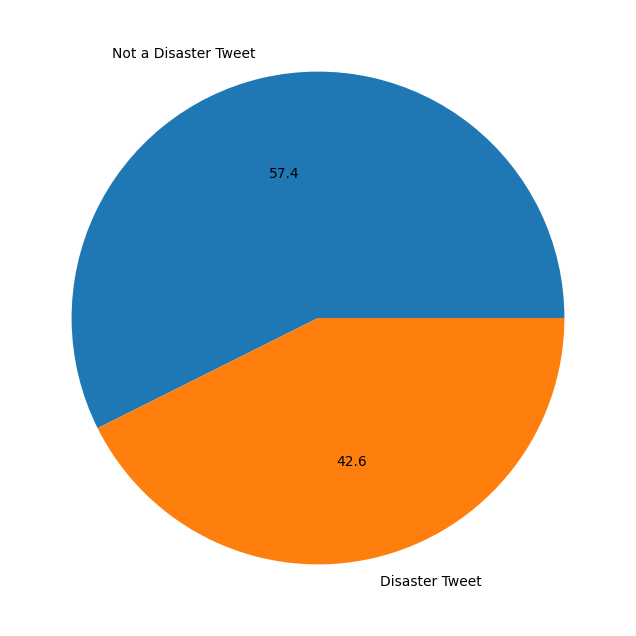

In [15]:
label_count = train_df1.target.value_counts()
print(label_count)

plt.figure(figsize = (10,8))
plt.pie(label_count, labels=['Not a Disaster Tweet', 'Disaster Tweet'], autopct='%1.1f')
plt.show()

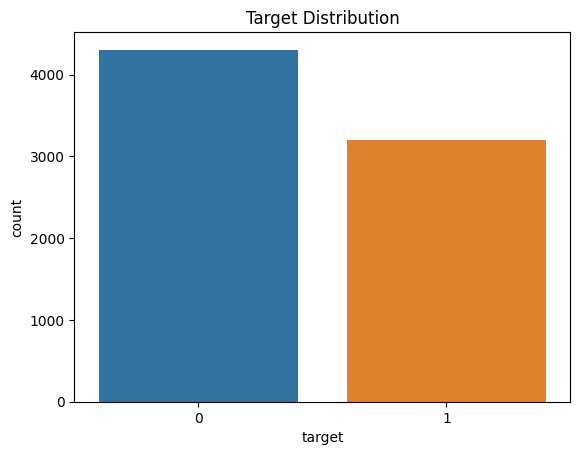

/tmp/ipykernel_30/2933428824.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1['text_length'] = train_df1['text'].apply(lambda x: len(x.split()))
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


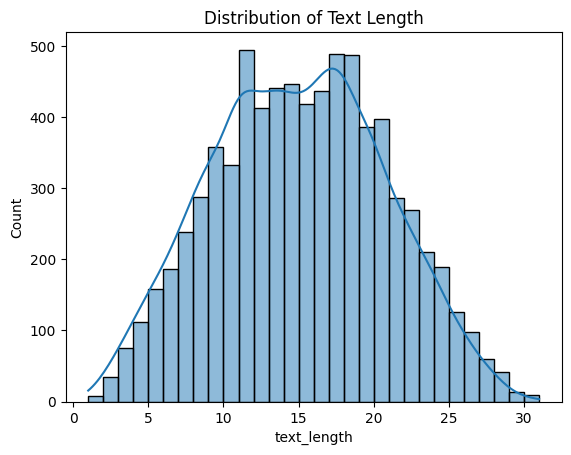

In [16]:
sns.countplot(x='target', data=train_df1)
plt.title('Target Distribution')
plt.show()

# Distribution of text length
train_df1['text_length'] = train_df1['text'].apply(lambda x: len(x.split()))
sns.histplot(train_df1['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Length')
plt.show()

In [17]:
train_df1 = train_df1.dropna(subset=['text', 'target']).reset_index(drop=True)

In [18]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [19]:
# Text preprocessing
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply preprocessing to text column
train_df1['clean_text'] = train_df1['text'].apply(preprocess_text)

In [20]:
# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df1['clean_text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(train_df1['clean_text'])
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, train_df1['target'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [21]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.1),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.1),
    Bidirectional(LSTM(256)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

print(model.summary())

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 60s 590ms/step - accuracy: 0.6403 - loss: 0.6276 - val_accuracy: 0.7813 - val_loss: 0.4826
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 49s 586ms/step - accuracy: 0.9013 - loss: 0.2860 - val_accuracy: 0.7289 - val_loss: 0.7444
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 48s 579ms/step - accuracy: 0.9654 - loss: 0.1122 - val_accuracy: 0.7031 - val_loss: 0.7822
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 585ms/step - accuracy: 0.9746 - loss: 0.0823 - val_accuracy: 0.7609 - val_loss: 0.9225
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 49s 593ms/step - accuracy: 0.9842 - loss: 0.0474 - val_accuracy: 0.7449 - val_loss: 0.7201
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 49s 590ms/step - accuracy: 0.9906 - loss: 0.0342 - val_accuracy: 0.7360 - val_loss: 1.3779
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 48s 582ms/step - accuracy: 0.9953 - loss: 0.0193 - val_accuracy: 0.7324 - val_loss: 1.1536
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 49s 587ms/step - accuracy: 0.9946 - loss: 0.0165 - val

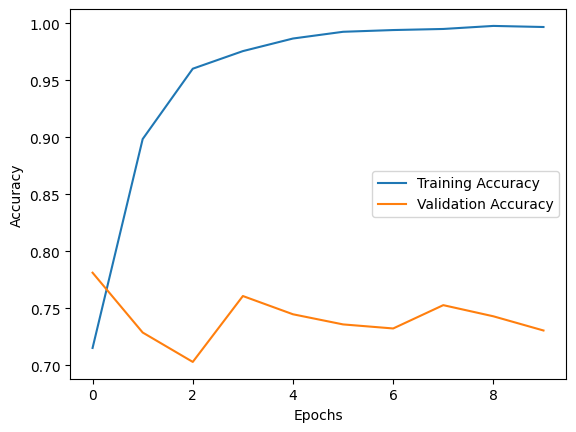

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step


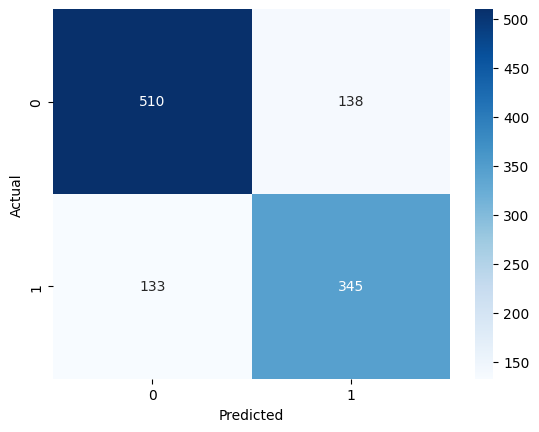

In [22]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
# Ensure necessary imports are in place
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preprocess the test dataset
test_df['clean_text'] = test_df['text'].apply(preprocess_text)

# Convert test texts to sequences
test_sequences = tokenizer.texts_to_sequences(test_df['clean_text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Predict on the test data
test_predictions = (model.predict(test_padded_sequences) > 0.5).astype("int32")

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions.flatten()  # Flatten to make the array compatible
})

# Save the submission file
submission_file_path = '/kaggle/working/submission.csv'
submission.to_csv(submission_file_path, index=False)

submission_file_path


102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step


'/kaggle/working/submission.csv'